In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import itertools
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np



In [ ]:
# cluster_map = pd.read_csv('plotting_script/data/cluster_info.tsv', sep='\t')

# dle_info = pd.read_csv('plotting_script/data/protein_info.tsv', sep='\t')

# # display(cluster_map.head(), dle_info.head())

In [ ]:
# merged_df = dle_info.merge(cluster_map, on='Uniref', how='left')

# display(merged_df.head())


In [ ]:
# merged_df.drop(merged_df.columns[6], axis=1, inplace=True)
# merged_df.drop(merged_df.columns[6], axis=1, inplace=True)

# display(merged_df.head())



In [29]:
# merged_df.to_csv('plotting_script/data/merged_info.tsv', sep='\t', index=False)

In [3]:
merged_df = pd.read_csv('plotting_script/data/merged_info.tsv', sep='\t')

In [3]:
# Calculate the occurrence of each domain in each cluster
domain_occurrences = defaultdict(lambda: defaultdict(int))
total_domains_per_cluster = defaultdict(int)

for index, row in merged_df.iterrows():
    cluster_id = row['dl_endopeptidase-foldseek_cluster']
    domains = row['Interpro']
    
    if pd.notnull(domains):
        for domain in eval(domains):
            domain_occurrences[cluster_id][domain] += 1
            total_domains_per_cluster[cluster_id] += 1

# Calculate the percentage of each domain in each cluster
domain_percentages = {cluster: {domain: count / total_domains_per_cluster[cluster] 
                                for domain, count in domains.items()} 
                      for cluster, domains in domain_occurrences.items()}

# Convert domain percentages to a matrix for similarity calculation
# Create a list of all unique domains across all clusters
all_domains = set(domain for cluster_domains in domain_percentages.values() for domain in cluster_domains.keys())

# Create a matrix of domain percentages for each cluster
cluster_ids = list(domain_percentages.keys())
domain_matrix = np.zeros((len(cluster_ids), len(all_domains)))

# Mapping of cluster IDs and domain indices to facilitate matrix population
cluster_idx_map = {cluster_id: idx for idx, cluster_id in enumerate(cluster_ids)}
domain_idx_map = {domain: idx for idx, domain in enumerate(all_domains)}

# Populate the matrix with domain percentages
for cluster_id, domains in domain_percentages.items():
    for domain, percentage in domains.items():
        cluster_idx = cluster_idx_map[cluster_id]
        domain_idx = domain_idx_map[domain]
        domain_matrix[cluster_idx, domain_idx] = percentage

# Calculate cosine similarity between clusters based on domain matrix
cosine_sim = cosine_similarity(domain_matrix)

# Convert the similarity matrix to edge list for significant similarities
# We consider a similarity significant if it's above 0.1 (can adjust)
significant_similarity_threshold = 0.1
significant_edges = [(cluster_ids[i], cluster_ids[j], cosine_sim[i, j]) 
                     for i in range(len(cluster_ids)) 
                     for j in range(i+1, len(cluster_ids)) 
                     if cosine_sim[i, j] > significant_similarity_threshold]

In [ ]:
# Create the network graph
G_adjusted_similarity = nx.Graph()

# Add nodes (clusters)
G_adjusted_similarity.add_nodes_from(cluster_ids)

# Add edges with weights based on cosine similarity
G_adjusted_similarity.add_weighted_edges_from(significant_edges)

downregulated_clusters = [
    "A0A1C6G745",
    "A0A829ZMP2",
    "A0A1C6FAW9",
    "A0A174TDS3",
    "R6MIH8",
    "A0A1C5VJV2",
    "A0A0B0HUJ2",
    "R6YTV6",
    "A0A1Y6AQ80",
    "A0A6N3BHG0"
]

# Assign colors to nodes based on whether they are downregulated in CRC
node_colors = ["red" if node in downregulated_clusters else "blue" for node in G_adjusted_similarity.nodes()]

# Step 1: Calculate the size of each cluster
cluster_sizes = merged_df['dl_endopeptidase-foldseek_cluster'].value_counts().to_dict()

# Step 2: Map cluster sizes to node sizes for visualization
# Normalize cluster sizes to a suitable range for node sizes in the graph (e.g., between 20 and 1000)
min_size = 20
max_size = 1000
min_cluster_size = min(cluster_sizes.values())
max_cluster_size = max(cluster_sizes.values())
node_sizes = [
    ((cluster_sizes[node] - min_cluster_size) / (max_cluster_size - min_cluster_size) * (max_size - min_size) + min_size)
    if node in cluster_sizes else min_size
    for node in G_adjusted_similarity.nodes()
]

# Visualize the adjusted network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_adjusted_similarity, seed=42)  # For consistent layout

# Draw the network
nx.draw_networkx_nodes(G_adjusted_similarity, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8)
nx.draw_networkx_edges(G_adjusted_similarity, pos, alpha=0.5)
nx.draw_networkx_labels(G_adjusted_similarity, pos, font_size=5, alpha=0.7)

plt.title("Adjusted Network Graph Based on Percentage Domain Inclusion")
plt.axis('off')
plt.savefig('../../figures/adjusted_network.png', dpi=600, bbox_inches='tight')

In [6]:
display(merged_df.head())

,# ID,Genome,Prediction,Uniref,Lineage,Interpro,dl_endopeptidase-foldseek_cluster
0,MGYG000155050_27_22,MGYG000155050,OTHER,A0A3S5AQD8,d__Bacteria;p__Firmicutes;c__Bacilli;o__RFN20;...,"['Endopeptidase, NLPC/P60 domain']",A0A1C5WD06
1,MGYG000096674_74_7,MGYG000096674,OTHER,A0A1C6G2Q5,d__Bacteria;p__Firmicutes;c__Bacilli;o__RFN20;...,"['Endopeptidase, NLPC/P60 domain']",A0A1C5WD06
2,MGYG000074457_25_259,MGYG000074457,SP,A0A3P1BK63,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...,"['Endopeptidase, NLPC/P60 domain', 'SH3-like d...",A0A1V6BVN9
3,MGYG000074457_44_345,MGYG000074457,SP,A0A2S9XVU2,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...,"['Endopeptidase, NLPC/P60 domain', 'Bacterial ...",A0A1V5YPB2
4,MGYG000002288_3_33,MGYG000002288,SP,A0A3P1BK63,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...,"['Endopeptidase, NLPC/P60 domain', 'SH3-like d...",A0A1V6BVN9


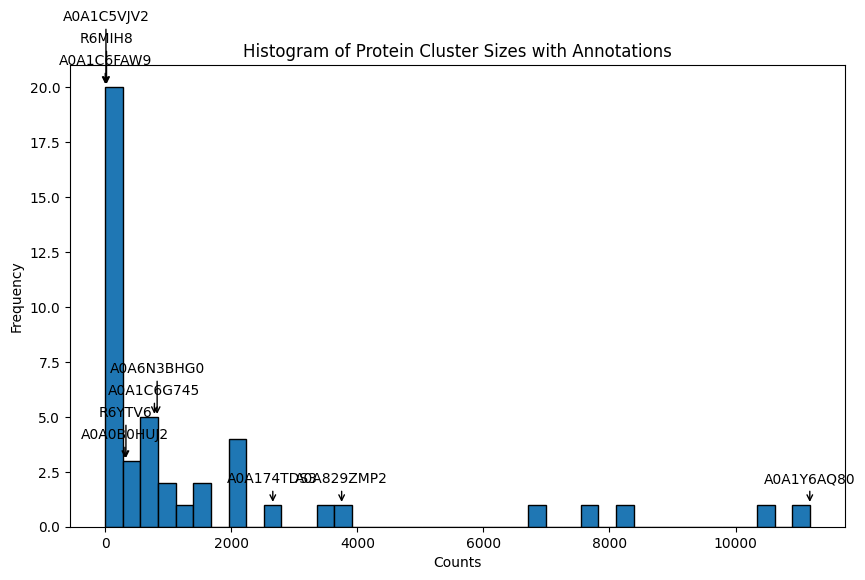

In [31]:
# cluster_df = merged_df.groupby('dl_endopeptidase-foldseek_cluster')['Uniref'].count()
# print(cluster_df)


cluster_df = merged_df.groupby('dl_endopeptidase-foldseek_cluster')['Uniref'].count().sort_values(ascending=False)
# print(cluster_df)

cluster_df = pd.DataFrame(cluster_df).reset_index()

cluster_df = cluster_df.rename(columns={'dl_endopeptidase-foldseek_cluster': 'Cluster', 'Uniref': 'Counts'})

downregulated_clusters = [
    "A0A1C6G745",
    "A0A829ZMP2",
    "A0A1C6FAW9",
    "A0A174TDS3",
    "R6MIH8",
    "A0A1C5VJV2",
    "A0A0B0HUJ2",
    "R6YTV6",
    "A0A1Y6AQ80",
    "A0A6N3BHG0"
]

plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(cluster_df['Counts'], bins=40, edgecolor='black')

# Calculate the maximum frequency 
max_frequency = max(n)

# Manage overlapping annotations by tracking the y-positions used
y_positions = {}

# Annotating specific cluster IDs
for cluster in downregulated_clusters:
    count = cluster_df.loc[cluster_df['Cluster'] == cluster, 'Counts'].values[0]
    bin_index = (count - bins[0]) // (bins[1] - bins[0])
    bin_height = n[int(bin_index)]
    base_y_position = bin_height + 0.05 * max_frequency  # Initial position above the bin

    # Adjust y position if there is an overlap
    position_adjusted = False
    while not position_adjusted:
        if base_y_position in y_positions and abs(y_positions[base_y_position] - count) < 100:
            base_y_position += 0.05 * max_frequency  # Increment to avoid overlap
        else:
            y_positions[base_y_position] = count
            position_adjusted = True

    # Add annotation with an arrow
    plt.annotate(cluster, (count, bin_height), xytext=(count, base_y_position),
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), ha='center')

plt.title('Histogram of Protein Cluster Sizes with Annotations')
plt.xlabel('Counts')
plt.ylabel('Frequency')
plt.show()






